# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


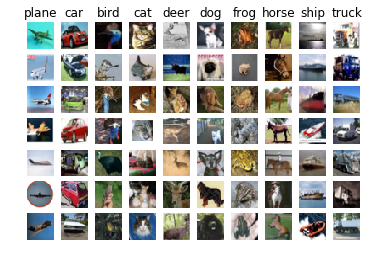

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


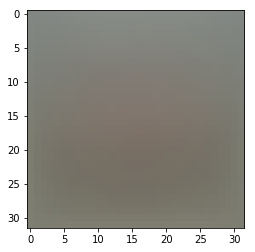

In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [8]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [9]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [11]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.127600


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [12]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -18.790337 analytic: -18.790337, relative error: 6.105113e-13
numerical: -7.282639 analytic: -7.282639, relative error: 7.324304e-11
numerical: -18.435660 analytic: -18.435660, relative error: 1.047276e-12
numerical: -11.032868 analytic: -11.032868, relative error: 1.235632e-11
numerical: -14.133388 analytic: -14.133388, relative error: 1.130902e-11
numerical: 1.268127 analytic: 1.268127, relative error: 8.981866e-11
numerical: -6.670708 analytic: -6.670708, relative error: 4.695096e-11
numerical: 10.381247 analytic: 10.381247, relative error: 1.139179e-12
numerical: -6.617556 analytic: -6.617556, relative error: 5.934633e-11
numerical: -10.814748 analytic: -10.814748, relative error: 1.081385e-11
numerical: -30.226102 analytic: -30.226102, relative error: 9.058884e-12
numerical: -6.225074 analytic: -6.225074, relative error: 4.971914e-11
numerical: 5.945123 analytic: 5.945123, relative error: 5.564558e-12
numerical: 29.697264 analytic: 29.697264, relative error: 2.097012e-1

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

1. Yes because computers have difficulty storing floating point numbers to a high degree of accuracy. Because of this, computing the same formula or eqivelent formulas twice might give different results if, as in the case with the kinds of gradients we're dealing with, there are a lot of floating point numbers involved.
2. This is probably not a reason for concern, since these differences are almost always tiny, and the whole point of calculating the gradient is to get a rough idea of how to update our parameters, so tiny, random discrepancies are not an issue.
3. 

In [31]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.127600e+00 computed in 0.075812s
(500,)
(500, 10)
4563.799779327361
9.12759955865472
9.12759956022029
(500, 10)
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 8 9 9 9 9 9 9 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 8 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 7 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 7 9 9 9 8 7 9 9 6 9 9 8 9 9 9 9 9 9 9 9 9 9 9 8 9 9 8 9 9 9 9
 9 6 9 9 9 9 9 9 9 8 9 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 9 9 9 9 9
 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 

In [38]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.073928s
(500,)
(500, 10)
4563.799779327361
9.12759955865472
9.12759956022029
Vectorized loss and gradient: computed in 0.005557s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [44]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

(200,)
(200, 10)
4891.113886601341
24.455569433006705
799.0094596068964
done once
iteration 0 / 1500: loss 799.009460
(200,)
(200, 10)
4423.112065946203
22.115560329731014
788.8512968277854
done once
(200,)
(200, 10)
3534.2266114017802
17.671133057008902
776.6773827490251
done once
(200,)
(200, 10)
4394.428531347341
21.972142656736704
773.3451723751589
done once
(200,)
(200, 10)
3933.4087960013094
19.667043980006547
763.4641292105398
done once
(200,)
(200, 10)
3859.1683047026477
19.29584152351324
755.6029670730643
done once
(200,)
(200, 10)
3748.21599890723
18.74107999453615
747.6354850168078
done once
(200,)
(200, 10)
3741.3558391942706
18.706779195971354
740.2641054033238
done once
(200,)
(200, 10)
3641.7060443601176
18.208530221800586
732.5028131615261
done once
(200,)
(200, 10)
3810.088566700285
19.050442833501425
726.1567227209578
done once
(200,)
(200, 10)
3531.6444144648563
17.658222072324282
717.6444750894361
done once
(200,)
(200, 10)
3308.117067418491
16.540585337092455
709.4

265.6266273700439
done once
(200,)
(200, 10)
1693.2994249593594
8.466497124796797
263.7040043475909
done once
(200,)
(200, 10)
1566.0773985846909
7.830386992923454
260.50467099077565
done once
(200,)
(200, 10)
1688.1476317776178
8.440738158888088
258.5798979654212
done once
(200,)
(200, 10)
1655.4164275184926
8.277082137592464
255.9052262200618
done once
(200,)
(200, 10)
1520.106031640383
7.600530158201915
252.74228651108268
done once
(200,)
(200, 10)
1686.8430690327389
8.434215345163695
251.11732231836677
done once
(200,)
(200, 10)
1560.2599292312227
7.801299646156114
248.04714047264926
done once
(200,)
(200, 10)
1527.1543492691735
7.635771746345868
245.4709945158516
done once
(200,)
(200, 10)
1671.2876400051355
8.356438200025677
243.80604025210147
done once
(200,)
(200, 10)
1352.595450580644
6.7629772529032195
239.84841147130481
done once
(200,)
(200, 10)
1685.4631132906634
8.427315566453316
239.17772962508394
done once
(200,)
(200, 10)
1526.6795626289343
7.633397813144671
236.064869

(200,)
(200, 10)
1252.2995229601004
6.2614976148005015
85.60999453001895
done once
(200,)
(200, 10)
1092.2724258540754
5.461362129270377
84.01338383220249
done once
(200,)
(200, 10)
1146.8302036588811
5.734151018294406
83.50129304049612
done once
(200,)
(200, 10)
1126.1715667046085
5.630857833523042
82.6188698952012
done once
(200,)
(200, 10)
1137.4035713449794
5.687017856724896
81.90510060417436
done once
(200,)
(200, 10)
1036.5119257613496
5.182559628806748
80.63863198336857
done once
(200,)
(200, 10)
1109.444770649778
5.547223853248891
80.25057492385058
done once
(200,)
(200, 10)
1013.5180000388109
5.067590000194055
79.02406312522707
done once
(200,)
(200, 10)
1129.4824313329586
5.647412156664793
78.86591862878898
done once
(200,)
(200, 10)
974.031035975848
4.87015517987924
77.35624936312725
done once
(200,)
(200, 10)
1136.9250848861207
5.684625424430603
77.4487174464936
done once
(200,)
(200, 10)
1123.6832711615875
5.618416355807938
76.66490677853884
done once
(200,)
(200, 10)
1123

(200,)
(200, 10)
1015.1240189136442
5.0756200945682215
30.95892760323111
done once
(200,)
(200, 10)
988.401525652956
4.94200762826478
30.568656746830005
done once
(200,)
(200, 10)
1073.10235251519
5.36551176257595
30.73823631931376
done once
(200,)
(200, 10)
937.1384444588496
4.685692222294247
29.806641691511377
done once
(200,)
(200, 10)
851.729205796712
4.25864602898356
29.133112864895928
done once
(200,)
(200, 10)
991.333970417402
4.9566698520870105
29.587796669467732
done once
(200,)
(200, 10)
971.8432271608417
4.859216135804209
29.24782670798426
done once
(200,)
(200, 10)
990.1587767608585
4.950793883804292
29.098649649150428
done once
(200,)
(200, 10)
1054.5795163271625
5.272897581635813
29.183340217551507
done once
(200,)
(200, 10)
1075.1918751672195
5.375959375836097
29.049428869392848
done once
(200,)
(200, 10)
1120.8317550774022
5.6041587753870115
29.042941612552987
done once
(200,)
(200, 10)
993.4258507675402
4.967129253837701
28.173862741879404
done once
(200,)
(200, 10)
10

13.781495412740838
done once
(200,)
(200, 10)
1031.6312198629191
5.158156099314596
13.887878644207484
done once
(200,)
(200, 10)
936.8762186687436
4.684381093343718
13.329036638840847
done once
(200,)
(200, 10)
995.9062891522399
4.979531445761199
13.541314266332428
done once
(200,)
(200, 10)
965.7988207315857
4.828994103657928
13.309057550600508
done once
(200,)
(200, 10)
1064.6554777640936
5.323277388820468
13.722432367503512
done once
(200,)
(200, 10)
892.4047195235357
4.462023597617678
12.780872002418288
done once
(200,)
(200, 10)
956.128009173497
4.780640045867485
13.021998133478643
done once
(200,)
(200, 10)
957.1008830713624
4.7855044153568125
12.949478814845857
done once
(200,)
(200, 10)
1010.8912746134301
5.054456373067151
13.142658557745788
done once
(200,)
(200, 10)
1041.6789125144508
5.208394562572254
13.219755506780173
done once
(200,)
(200, 10)
1023.8574660537897
5.119287330268949
13.053253988392603
done once
(200,)
(200, 10)
1031.57004099889
5.15785020499445
13.0156532101

(200,)
(200, 10)
1008.8695366557131
5.044347683278565
8.088479591433412
done once
(200,)
(200, 10)
931.5508809204387
4.657754404602193
7.675212343137137
done once
(200,)
(200, 10)
905.1560814747265
4.525780407373633
7.518981633731431
done once
(200,)
(200, 10)
990.0105040592175
4.950052520296087
7.917120305622775
done once
(200,)
(200, 10)
996.6159311568715
4.9830796557843575
7.925715534154026
done once
(200,)
(200, 10)
966.7684429171245
4.833842214585623
7.750818414697
done once
(200,)
(200, 10)
1016.6231929320575
5.083115964660287
7.975349813669651
done once
(200,)
(200, 10)
985.3588133135199
4.9267940665675996
7.792943587989075
done once
(200,)
(200, 10)
1052.8220396821366
5.264110198410683
8.106864834023805
done once
(200,)
(200, 10)
1013.2985900957726
5.066492950478863
7.883633770473842
done once
(200,)
(200, 10)
935.9142308622806
4.679571154311403
7.4730251315761365
done once
(200,)
(200, 10)
856.7521050431785
4.283760525215893
7.054959959905144
done once
(200,)
(200, 10)
882.249

done once
(200,)
(200, 10)
954.3281213307541
4.77164060665377
6.103460127977066
done once
(200,)
(200, 10)
885.6119173200295
4.428059586600147
5.7512015871764035
done once
(200,)
(200, 10)
941.6216949619632
4.708108474809816
6.0234396818116895
done once
(200,)
(200, 10)
932.9908793270927
4.664954396635463
5.971897531347773
done once
(200,)
(200, 10)
1050.3400460622431
5.251700230311216
6.551654065192055
done once
(200,)
(200, 10)
1061.5268234780078
5.307634117390039
6.599523531918152
done once
(200,)
(200, 10)
869.298946429431
4.346494732147155
5.629367447037357
done once
(200,)
(200, 10)
1033.4751120943424
5.167375560471712
6.443395824107836
done once
(200,)
(200, 10)
1065.0608962558092
5.325304481279046
6.592928683079657
done once
(200,)
(200, 10)
1009.9544540198231
5.0497722700991154
6.308014749767481
done once
(200,)
(200, 10)
1008.5384727052033
5.042692363526016
6.292903459871047
done once
(200,)
(200, 10)
1000.1091278664908
5.000545639332454
6.243632768713749
done once
(200,)
(20

(200, 10)
947.2138615290589
4.736069307645295
5.399912217521287
done once
(200,)
(200, 10)
903.5750032718147
4.517875016359073
5.178883002724756
done once
(200,)
(200, 10)
1033.7189648509834
5.168594824254917
5.829105500479603
done once
(200,)
(200, 10)
1047.6774288427885
5.2383871442139425
5.896063122602118
done once
(200,)
(200, 10)
935.0988977008094
4.675494488504047
5.330452210021719
done once
(200,)
(200, 10)
1013.0457647471219
5.06522882373561
5.719332354692386
done once
(200,)
(200, 10)
959.4110981150134
4.797055490575067
5.448467498341559
done once
(200,)
(200, 10)
1047.3155390105946
5.236577695052973
5.88677339331504
done once
(200,)
(200, 10)
931.099621287321
4.655498106436605
5.303064919212529
done once
(200,)
(200, 10)
884.9430272548548
4.424715136274274
5.071506855215494
done once
(200,)
(200, 10)
878.2871148166018
4.391435574083009
5.03616102850196
done once
(200,)
(200, 10)
989.4156003849621
4.947078001924811
5.591646506721126
done once
(200,)
(200, 10)
986.1591184620825

5.347670039009773
done once
(200,)
(200, 10)
974.0261639162172
4.870130819581086
5.397969073227664
done once
(200,)
(200, 10)
934.6154378695217
4.673077189347608
5.199798911991659
done once
(200,)
(200, 10)
966.3356990325801
4.831678495162901
5.36026924327791
done once
(200,)
(200, 10)
864.3108244615182
4.3215541223075915
4.849449735690197
done once
(200,)
(200, 10)
1013.4208626384802
5.067104313192401
5.595243859361124
done once
(200,)
(200, 10)
958.9116803654231
4.794558401827115
5.321406983298132
done once
(200,)
(200, 10)
952.485663568774
4.76242831784387
5.289686132946525
done once
(200,)
(200, 10)
981.9493925909082
4.909746962954541
5.435753502834521
done once
(200,)
(200, 10)
1065.421605278039
5.327108026390195
5.852067799358681
done once
(200,)
(200, 10)
1089.8713873872637
5.449356936936319
5.972798583642281
done once
(200,)
(200, 10)
935.2950366557636
4.676475183278818
5.198557019026475
done once
(200,)
(200, 10)
943.2339686040013
4.7161698430200065
5.238348711263444
done once

done once
(200,)
(200, 10)
894.048944449688
4.47024472224844
4.952238861929305
done once
(200,)
(200, 10)
1036.3552646556113
5.181776323278057
5.664858081115259
done once
(200,)
(200, 10)
991.6132020534474
4.9580660102672365
5.441165692223192
done once
(200,)
(200, 10)
907.9323672087864
4.5396618360439325
5.02196414497993
done once
(200,)
(200, 10)
998.7191745120697
4.993595872560348
5.4761219854750705
done once
(200,)
(200, 10)
1057.0361666967187
5.285180833483594
5.766509137190087
done once
(200,)
(200, 10)
1000.3866343596183
5.0019331717980915
5.480855913426427
done once
(200,)
(200, 10)
1068.1278950784608
5.3406394753923045
5.820266785449361
done once
(200,)
(200, 10)
941.8280325506216
4.709140162753108
5.187643683160147
done once
(200,)
(200, 10)
857.8779407666559
4.2893897038332796
4.768654069388871
done once
(200,)
(200, 10)
981.865640876546
4.90932820438273
5.38957230143046
done once
(200,)
(200, 10)
993.3768494619226
4.966884247309613
5.446759471716726
done once
(200,)
(200, 1

(200,)
(200, 10)
902.457793105568
4.512288965527841
4.9745387205829195
done once
(200,)
(200, 10)
1023.4763189691271
5.117381594845636
5.580585026092337
done once
(200,)
(200, 10)
907.7785547848205
4.538892773924102
5.0024187557271045
done once
(200,)
(200, 10)
932.671877921965
4.663359389609825
5.1289606141174815
done once
(200,)
(200, 10)
968.6446232952135
4.843223116476067
5.308785924059478
done once
(200,)
(200, 10)
966.5785222332624
4.832892611166312
5.2991732576838455
done once
(200,)
(200, 10)
970.3269737762835
4.851634868881417
5.318178735468857
done once
(200,)
(200, 10)
1002.0635550897109
5.010317775448555
5.475816477407117
done once
(200,)
(200, 10)
1007.9877694063002
5.039938847031501
5.504704195316304
done once
(200,)
(200, 10)
1002.5784986190056
5.012892493095028
5.475208334510605
done once
(200,)
(200, 10)
927.3563496461591
4.636781748230796
5.098056510995491
done once
(200,)
(200, 10)
941.1625823286422
4.705812911643211
5.166713659403099
done once
(200,)
(200, 10)
1122.

951.6475307438718
4.758237653719359
5.211956383637048
done once
(200,)
(200, 10)
912.1085516350636
4.560542758175318
5.0133924625121375
done once
(200,)
(200, 10)
1036.466767373769
5.182333836868845
5.637573873793497
done once
(200,)
(200, 10)
899.2006396078862
4.496003198039431
4.950446207376585
done once
(200,)
(200, 10)
962.9813081459029
4.814906540729514
5.270179263166959
done once
(200,)
(200, 10)
887.9439400454155
4.439719700227077
4.895322520136654
done once
(200,)
(200, 10)
919.2456051323363
4.596228025661682
5.051984694513474
done once
(200,)
(200, 10)
1053.4527370760002
5.267263685380001
5.722452597310152
done once
(200,)
(200, 10)
1041.001301042624
5.205006505213119
5.6586751408606295
done once
(200,)
(200, 10)
979.065876200639
4.895329381003195
5.348217379329213
done once
(200,)
(200, 10)
939.8785742826681
4.69939287141334
5.153957546526387
done once
(200,)
(200, 10)
970.0384163261238
4.8501920816306185
5.305765883004019
done once
(200,)
(200, 10)
946.7524313145775
4.733762

1044.8863588763343
5.224431794381672
5.676479647026859
done once
(200,)
(200, 10)
964.9319032182993
4.824659516091497
5.275355342480089
done once
(200,)
(200, 10)
992.3126491033659
4.961563245516829
5.412566436547636
done once
(200,)
(200, 10)
926.5017202933836
4.632508601466919
5.083041027536544
done once
(200,)
(200, 10)
936.2666793768749
4.681333396884375
5.133931326847189
done once
(200,)
(200, 10)
907.4894327682769
4.537447163841384
4.991096667807013
done once
(200,)
(200, 10)
1064.1777657660723
5.320888828830362
5.776116569378387
done once
(200,)
(200, 10)
1006.4177312676175
5.032088656338087
5.486314840460415
done once
(200,)
(200, 10)
988.3279965548295
4.941639982774148
5.394499578742783
done once
(200,)
(200, 10)
930.3694461782866
4.651847230891433
5.105554698601265
done once
(200,)
(200, 10)
921.2109297699037
4.606054648849518
5.059691792924346
done once
(200,)
(200, 10)
1027.8613150043827
5.139306575021914
5.592818572710347
done once
(200,)
(200, 10)
977.2348040202783
4.8861

done once
(200,)
(200, 10)
1000.7307504418659
5.003653752209329
5.458064322144887
done once
(200,)
(200, 10)
951.9702684722415
4.759851342361207
5.213824698815483
done once
(200,)
(200, 10)
916.009865156946
4.580049325784731
5.034699167272582
done once
That took 5.678622s


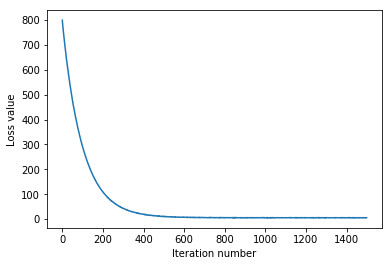

In [45]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [54]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.371286
validation accuracy: 0.369000


In [64]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [0.8e-7, 1.2e-7, 1e-7]
regularization_strengths = [8.5e4, 8.2e4, 8.9e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=400, verbose=True)
        y_train_pred = svm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        
        y_val_pred = svm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        
        results[(lr, rs)] = (train_acc, val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
            
        print("done one iteration")

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

3958.0213664652774
19.790106832326387
2665.5507348286264
done once
iteration 0 / 400: loss 2665.550735
4037.792412399539
20.188962061997696
2594.2851456460694
done once
4176.98108255477
20.88490541277385
2525.2448180541246
done once
3363.8327467645786
16.819163733822894
2453.318675515643
done once
3746.9040054312836
18.734520027156417
2389.255873659104
done once
3551.284696406112
17.75642348203056
2324.0624673997313
done once
3754.8722138206685
18.774361069103342
2262.6112388999413
done once
3721.052530479388
18.60526265239694
2201.6456531126996
done once
3233.6418576959786
16.168209288479893
2140.061165950704
done once
3594.237034792507
17.971185173962535
2084.343154417339
done once
3420.6081983518097
17.10304099175905
2027.48743391177
done once
3032.991251449266
15.164956257246331
1971.0831489524967
done once
3221.9436814333153
16.109718407166575
1919.0552364148605
done once
3077.519461519587
15.387597307597934
1866.7868933769028
done once
2863.071089454167
14.315355447270836
1815.56

done once
1023.2504562007853
5.116252281003926
22.527426239035957
done once
1154.0367808168066
5.770183904084033
22.726829838144496
done once
1131.770152693301
5.658850763466505
22.173238233124493
done once
1114.437892548716
5.57218946274358
21.655105531373795
done once
1087.0810536539059
5.4354052682695295
21.0982872629365
done once
1103.4118738873763
5.517059369436882
20.770970670514185
done once
1008.8747238642945
5.0443736193214725
19.89934370936198
done once
947.972146266924
4.73986073133462
19.20967463968761
done once
1085.4080708366525
5.427040354183263
19.523470966146697
done once
1081.1971412057164
5.4059857060285825
19.136031425719395
done once
1021.2397421408327
5.106198710704164
18.479502441661225
done once
1061.0910570083583
5.305455285041791
18.33438242102229
done once
1035.56235786154
5.1778117893077
17.868093890215007
done once
1162.2185363463223
5.811092681731611
18.17270636953438
done once
1016.7064183764203
5.083532091882102
17.121899061125983
done once
1088.03159385

1030.8149449614855
5.154074724807427
5.854076983305641
done once
1107.0320506128278
5.535160253064139
6.23691341952112
done once
1133.7198027177665
5.668599013588833
6.363911277753715
done once
1170.1234535566591
5.850617267783296
6.541508390435987
done once
1019.127522580809
5.095637612904045
5.784608265173382
done once
1053.556369873266
5.26778184936633
5.955036650524654
done once
1102.478818974178
5.51239409487089
6.199361495775413
done once
1099.6164327283013
5.498082163641507
6.18217644198716
done once
1199.8231902917737
5.999115951458869
6.682011127950246
done once
1002.5850991824586
5.0129254959122935
5.6908759398978495
done once
1138.5746684650342
5.6928733423251705
6.37327201799297
done once
1038.307092492092
5.191535462460459
5.868239404139035
done once
1098.3354987509717
5.4916774937548585
6.170031848223927
done once
1009.6102668041244
5.048051334020622
5.724132336517004
done once
1060.818614881146
5.30409307440573
5.979190326091624
done once
1003.6000525237241
5.01800026261

1358.952310015461
6.794761550077306
126.37232760705615
done once
1043.3112983952801
5.216556491976401
121.6717546524768
done once
1196.5312596181584
5.982656298090792
119.40899957268145
done once
1274.6029393031022
6.373014696515511
116.84484988207787
done once
1376.165426879501
6.880827134397505
114.47301414413822
done once
1197.2820921947784
5.986410460973892
110.76828721261444
done once
1163.8875697338708
5.819437848669354
107.87475764708829
done once
1289.336095730031
6.446680478650155
105.84429966683798
done once
1208.4616281347965
6.042308140673982
102.85202184398872
done once
1251.0531141605913
6.2552655708029565
100.545508906891
done once
1210.2384419754153
6.051192209877076
97.88746128724408
done once
1242.3145025228714
6.211572512614357
95.65916843248021
done once
1237.2237621663946
6.186118810831974
93.30532268165462
done once
1094.1835492503587
5.470917746251794
90.32131630607684
done once
1160.3788206051881
5.8018941030259406
88.45151162511006
done once
1148.355096934601
5

done once
1101.7845058409866
5.508922529204933
7.1036040936225735
done once
1040.1815145177834
5.200907572588917
6.769718896579891
done once
1028.310000537519
5.1415500026875955
6.685159639478687
done once
1042.2859218105345
5.211429609052673
6.733442223193944
done once
1006.1765254746692
5.030882627373346
6.528494934571359
done once
iteration 300 / 400: loss 6.528495
1093.3254847985477
5.466627423992739
6.940567946941968
done once
1099.5920537539278
5.4979602687696385
6.94574996210752
done once
1065.3465222555672
5.326732611277836
6.7500073568631915
done once
1117.2305340396674
5.586152670198337
6.988064847923498
done once
1107.7529802473427
5.538764901236714
6.918182249789349
done once
1058.637916517415
5.293189582587075
6.65326027829436
done once
1041.7431204483441
5.208715602241721
6.548345135561764
done once
1083.267522875948
5.41633761437974
6.737479278598293
done once
1010.8728910700765
5.054364455350383
6.352049940419997
done once
989.0016088940513
4.945008044470256
6.228007046

1455.5077285401017
7.277538642700509
485.21565465045575
done once
1436.8056228870091
7.184028114435046
471.580229901636
done once
1383.5930902376242
6.917965451188121
458.1590446634827
done once
1485.4055787292284
7.427027893646142
445.88392771599445
done once
1642.6123545012128
8.213061772506064
434.24347315005383
done once
1658.069303743758
8.29034651871879
422.2435765707011
done once
1315.3455987376615
6.576727993688308
408.79298908924136
done once
1432.6145539339045
7.163072769669522
397.98920085407906
done once
1373.8578099060146
6.869289049530073
386.62244509822915
done once
1102.2096489760797
5.511048244880398
374.5067517167441
done once
1269.8628725393946
6.3493143626969735
364.90315936927476
done once
1515.0429490325769
7.575214745162884
355.97561114113745
done once
1379.4535506416596
6.897267753208298
345.4235025524101
done once
1370.5824836264696
6.852912418132348
335.78678808885184
done once
1434.133241751016
7.17066620875508
326.7869467356369
done once
1361.310556894236
6.

1021.6579293480643
5.108289646740321
8.31142756937464
done once
1038.011459536215
5.190057297681075
8.323713533415281
done once
1025.0652372895222
5.125326186447611
8.190662352700787
done once
1134.186253709406
5.6709312685470294
8.66850162148969
done once
1137.4550689827324
5.687275344913662
8.611514083724256
done once
1043.4796417009752
5.217398208504876
8.073201146816622
done once
1106.72789134007
5.53363945670035
8.32852128854151
done once
1121.2049992541024
5.606024996270512
8.335213759376686
done once
1077.595880438526
5.38797940219263
8.053727522153984
done once
1051.3057940685237
5.256528970342618
7.863965558344959
done once
1109.8433744168537
5.549216872084269
8.101892060184356
done once
1111.4576394990236
5.557288197495118
8.054297216029543
done once
1098.4368266710999
5.492184133355499
7.933613487763118
done once
1046.997479894265
5.234987399471326
7.624535425981401
done once
1032.1625533067258
5.160812766533629
7.499849133158186
done once
1089.3294659314754
5.44664732965737

done one iteration
4511.961452241472
22.55980726120736
2653.109333403591
done once
iteration 0 / 400: loss 2653.109333
3822.567379922729
19.112836899613644
2543.0876413233273
done once
4027.778219824786
20.13889109912393
2441.905601931148
done once
4062.0892348576517
20.31044617428826
2343.9871935850297
done once
3640.292139513307
18.201460697566535
2247.744640956475
done once
3987.9254089362676
19.939627044681338
2159.1841963686493
done once
3636.6379017695863
18.18318950884793
2070.7491187033233
done once
3728.5068119710254
18.642534059855127
1988.0678624569914
done once
3262.0541327531446
16.310270663765724
1905.9441188396115
done once
2988.0099909239448
14.940049954619724
1828.041731990212
done once
3379.732622302203
16.898663111511013
1756.5873977761942
done once
2916.7474712715393
14.583737356357696
1683.7856488547825
done once
2891.513997362512
14.45756998681256
1616.061874266415
done once
2515.603498063106
12.578017490315531
1549.322847665168
done once
2771.4243614202123
13.857

1067.8250411683343
5.339125205841672
7.7723015828425135
done once
1005.7508421416326
5.028754210708163
7.383649129280651
done once
1060.2957426762619
5.301478713381309
7.586268865354728
done once
1081.922502535691
5.409612512678454
7.626457653299573
done once
1055.7061401894011
5.278530700947005
7.425604131629214
done once
1028.5177414663603
5.142588707331802
7.228362964233464
done once
1139.9670297691691
5.699835148845846
7.725065405907408
done once
990.4342538581691
4.9521712692908455
6.918180282818662
done once
1027.431921771105
5.137159608855525
7.0531236436500695
done once
1138.4044402614495
5.692022201307248
7.5602344720690695
done once
1044.9539091452887
5.224769545726443
7.039734445425966
done once
1088.295874285735
5.441479371428675
7.2106333809263345
done once
1006.3895206629413
5.031947603314706
6.756720258146508
done once
1063.4062142003177
5.317031071001589
7.000320766845548
done once
1092.9385024134933
5.464692512067467
7.103215926446602
done once
1056.1269367608402
5.280

999.7932130743063
4.9989660653715315
5.628405511320503
done once
1004.4310919291729
5.022155459645864
5.65683412146097
done once
1050.1959265501157
5.250979632750578
5.8910199869167545
done once
1092.9806335469298
5.464903167734649
6.104335226425974
done once
1036.3974554280953
5.181987277140476
5.817841730151688
done once
1114.9023254156627
5.574511627078314
6.210889124843774
done once
1092.1956957345114
5.4609784786725575
6.097005724084427
done once
1047.7301493124694
5.238650746562347
5.875469118379106
done once
1060.4836629540605
5.302418314770303
5.9430216246074
done once
1030.6963644414895
5.153481822207448
5.793456045689127
done once
976.0615431320816
4.880307715660408
5.522049060254919
done once
1059.3672603055466
5.296836301527732
5.942614521567326
done once
1007.145894236304
5.03572947118152
5.680809851222483
done once
1019.298234962353
5.096491174811765
5.742439958039401
done once
1004.1705696193421
5.020852848096711
5.668973372423663
done once
1108.9612944098558
5.544806472

1237.3516463839105
6.186758231919552
35.53858017789825
done once
1070.1010862766075
5.350505431383038
33.57539361424976
done once
1132.36784984755
5.661839249237749
32.80431297617612
done once
1115.72807385541
5.57864036927705
31.681673684259877
done once
1097.4179165967555
5.487089582983778
30.596642560968814
done once
1161.2859807020727
5.806429903510364
29.963406439748834
done once
1088.4082869287904
5.442041434643952
28.67478776838064
done once
1106.4784747476938
5.532392373738469
27.883192840225576
done once
1223.336614438011
6.116683072190056
27.612009657909994
done once
1019.7250437183479
5.09862521859174
25.77535691773407
done once
1141.26265853513
5.70631329267565
25.59998254661523
done once
1093.0964720257293
5.465482360128647
24.606355818017136
done once
1043.9462893667128
5.219731446833564
23.63490498659032
done once
1039.102571467903
5.195512857339516
22.916596550585844
done once
1167.0916100203738
5.8354580501018685
22.890872830420633
done once
1017.0000305408789
5.085000

5.6968395515655335
done once
1049.464057125368
5.247320285626841
5.876682956374846
done once
1022.4223446319779
5.11211172315989
5.74445151039496
done once
1172.0075117147003
5.860037558573501
6.49445185890883
done once
1072.5566046331157
5.362783023165579
5.993820308340487
done once
1118.8302118022548
5.594151059011274
6.226411553755424
done once
iteration 300 / 400: loss 6.226412
1022.0927692995949
5.110463846497975
5.739930993452051
done once
1068.5130560764403
5.3425652803822015
5.967873101944774
done once
1057.3298152784403
5.286649076392202
5.911024769763248
done once
1113.7771567405516
5.568885783702758
6.193010849037607
done once
1177.5410733928777
5.887705366964388
6.510909187313329
done once
1019.4063906035617
5.097031953017808
5.715069724623642
done once
1110.5553410490484
5.5527767052452415
6.180696433223168
done once
1158.8366395913008
5.794183197956504
6.420388812290724
done once
1099.8176911063629
5.4990884555318145
6.121727633238542
done once
1142.4719752996798
5.712359

1235.15037445621
6.175751872281051
163.0023531390498
done once
1281.9364324024953
6.409682162012476
156.60651760493752
done once
1158.9198939938333
5.7945994699691665
149.64186565895398
done once
1177.368028361081
5.886840141805405
143.6587711699531
done once
1160.8130917491749
5.804065458745875
137.76018141003777
done once
1167.3490303420854
5.836745151710427
132.2235391646978
done once
1205.986066054969
6.029930330274844
127.08405111081805
done once
1111.7440043444558
5.558720021722279
121.50539091536744
done once
1237.7799037625985
6.188899518812992
117.2464833424228
done once
1223.666672448967
6.118333362244835
112.48561088530761
done once
1170.2875345373366
5.851437672686683
107.72861898925724
done once
1176.5674811164408
5.882837405582205
103.46920114855892
done once
1083.0113192690571
5.415056596345286
98.88733110557231
done once
1110.2367419466834
5.551183709733417
95.08396884821734
done once
1058.8757044503743
5.294378522251872
91.05511745044905
done once
1090.7665021599446
5.

1176.1823553295808
5.8809117766479035
6.561831437400475
done once
1163.7875381348135
5.818937690674067
6.497949038708393
done once
1043.5834232468824
5.217917116234412
5.892987550662495
done once
1024.2480681711504
5.121240340855752
5.797956523993205
done once
1147.2623887425984
5.736311943712992
6.416182729444632
done once
1078.830468014677
5.3941523400733855
6.066437505044078
done once
1075.3378593103312
5.376689296551656
6.05167902862892
done once
1094.3773686783154
5.471886843391577
6.148859531912097
done once
1093.280285775353
5.466401428876765
6.143728638556018
done once
1171.969702549733
5.859848512748665
6.533328329891539
done once
1080.5999803483369
5.402999901741684
6.070221936347716
done once
997.4689599191163
4.987344799595581
5.648277201161842
done once
1084.9533724815258
5.424766862407629
6.096295053759882
done once
1139.3171572257388
5.696585786128694
6.366880632746068
done once
1026.1330747966763
5.130665373983382
5.801597923018358
done once
1022.0023441940564
5.1100117

done one iteration
3876.5573249839654
19.382786624919827
2627.464202387607
done once
iteration 0 / 400: loss 2627.464202
2781.9339747412128
13.909669873706063
2533.843355119987
done once
3779.7422857172314
18.898711428586157
2453.7318150389992
done once
3029.6643578847807
15.148321789423903
2367.6804646919354
done once
3219.076905743985
16.095384528719926
2289.1538605337814
done once
3210.5877484872403
16.0529387424362
2212.3023650303426
done once
2933.283972015495
14.666419860077474
2136.7010616354096
done once
3270.562006927919
16.352810034639596
2066.6949303394013
done once
3201.918570886437
16.009592854432185
1997.0539565674155
done once
2871.276939880191
14.356384699400955
1928.4411239333217
done once
2705.6087336024916
13.528043668012458
1862.9374671031699
done once
2837.0901129907734
14.185450564953866
1801.111432357164
done once
2670.5545523179553
13.352772761589776
1739.8924673666095
done once
2398.7919266711797
11.993959633355898
1680.1916064030818
done once
2607.012599629688

done once
1099.572965681164
5.49786482840582
37.943796144088694
done once
1135.4391848984123
5.677195924492062
37.044382328491814
done once
1021.2436702130153
5.106218351065077
35.43211495416716
done once
1079.2318108948086
5.396159054474043
34.722663639841834
done once
1038.2212528389723
5.191106264194861
33.548062613850135
done once
1068.4347308761803
5.342173654380901
32.763791476312036
done once
1137.5556246062458
5.687778123031229
32.20196612306934
done once
1109.5681586884107
5.547840793442053
31.18301005655193
done once
1119.5642340313298
5.5978211701566485
30.387750557784948
done once
1022.4724676200933
5.112362338100467
29.082670619532973
done once
1101.0621732806298
5.505310866403149
28.687662317856596
done once
1098.8441166217897
5.494220583108948
27.912803391875233
done once
1121.3107190102828
5.606553595051414
27.287185523842375
done once
1054.611675415053
5.273058377075265
26.242397859661946
done once
1067.8141752558438
5.339070876279219
25.622387095515204
done once
1088.

998.5658330270592
4.992829165135296
5.671137166260562
done once
998.2991895619057
4.991495947809528
5.671401591181775
done once
1034.715774871338
5.17357887435669
5.853566515470976
done once
1074.553281501927
5.372766407509634
6.054805084986331
done once
950.9806563236184
4.754903281618092
5.4349895512801085
done once
1011.2201869562327
5.056100934781163
5.74002911548035
done once
1017.1981874051371
5.085990937025685
5.770448638868179
done once
998.3219945194514
4.991609972597257
5.671371915787733
done once
1210.8489331624348
6.054244665812174
6.7334208353708105
done once
1092.1175270936033
5.460587635468016
6.130380858953069
done once
1132.5434267786422
5.662717133893211
6.332931887440078
done once
1090.901151533526
5.45450575766763
6.117938351499488
done once
1106.2596901995926
5.531298450997963
6.188332508095506
done once
1114.7745516626912
5.573872758313456
6.227082179108987
done once
1055.0567487443961
5.275283743721981
5.925080033187399
done once
1066.6742052424802
5.333371026212

345.8440069840132
done once
1409.548877406638
7.04774438703319
334.7087149963222
done once
1443.9487243556819
7.2197436217784094
324.20067928711296
done once
1419.101367074632
7.09550683537316
313.7423515318868
done once
1561.2063090838853
7.806031545419427
304.4552234289917
done once
1347.0143449469601
6.735071724734801
293.704370703064
done once
1368.8350774748355
6.844175387374178
284.45999359507834
done once
1395.7197729551513
6.978598864775757
275.5417098885564
done once
1243.0691179036176
6.215345589518088
266.02310533052355
done once
1134.1307643188698
5.670653821594349
257.01569715217784
done once
1558.5414319391016
7.7927071596955075
250.95670636015234
done once
1225.7655229290795
6.128827614645397
241.3567526780684
done once
1233.9099601757785
6.169549800878892
233.73953545486677
done once
1324.9482025136085
6.624741012568043
226.78889276329915
done once
1321.9349749792068
6.609674874896034
219.59617159218445
done once
1273.7483425200667
6.368741712600333
212.41644065833398
d

1075.6554923022481
5.3782774615112405
6.813796678384936
done once
1189.9826182357526
5.949913091178763
7.361891980543772
done once
1092.4735201262592
5.462367600631296
6.845918944309802
done once
1081.4223831576805
5.407111915788403
6.764995890388781
done once
1062.9434699597423
5.314717349798712
6.651007277638979
done once
1016.7825715333115
5.083912857666558
6.394657388138272
done once
1072.0809295443532
5.360404647721766
6.65124977550796
done once
1056.0920342291356
5.280460171145678
6.548318221616278
done once
1014.6596162930005
5.073298081465002
6.319801594225632
done once
1076.5916756118568
5.382958378059284
6.609479830766054
done once
1106.2269042787802
5.531134521393901
6.738617576619276
done once
1095.822995714443
5.479114978572215
6.661367541634972
done once
1066.6314339097357
5.333157169548679
6.497155362457725
done once
1058.5891362111138
5.292945681055569
6.437471329096729
done once
1048.6665261176129
5.243332630588064
6.376169273012778
done once
1018.8346889083559
5.09417

done one iteration
4401.482386270149
22.007411931350745
2749.1164920030033
done once
iteration 0 / 400: loss 2749.116492
3956.639292762725
19.783196463813624
2650.3822373034227
done once
4277.057694314124
21.38528847157062
2558.9153501279675
done once
4356.175569792138
21.78087784896069
2469.5037042283884
done once
3565.0096824370785
17.825048412185392
2378.9032079811445
done once
3516.5701977961126
17.582850988980564
2295.1330164856604
done once
3569.719341565535
17.848596707827674
2214.8272414644175
done once
3416.2146179582214
17.081073089791108
2136.3250726321294
done once
2953.5404084842594
14.767702042421297
2059.034419089579
done once
2713.116950472584
13.56558475236292
1985.5362572358133
done once
3118.221829639442
15.59110914819721
1917.8322368899742
done once
2829.7802106562367
14.148901053281184
1849.09587758174
done once
2777.747950624703
13.888739753123517
1783.935918903307
done once
2437.2672646665515
12.186336323332757
1719.6292986400915
done once
2424.992874254293
12.12

1055.8753571203104
5.279376785601552
15.393959209429827
done once
1002.5269201741587
5.012634600870793
14.79135608764761
done once
1132.418914227705
5.6620945711385255
15.119980070976471
done once
985.263293126857
4.926316465634285
14.064841333985381
done once
1125.0708206735494
5.625354103367747
14.466992908823546
done once
1114.9554079184677
5.574777039592338
14.121888156167696
done once
1042.37634980467
5.211881749023351
13.479321997836387
done once
1028.8705723920057
5.144352861960028
13.140682249770416
done once
1086.232927684524
5.4311646384226195
13.165036285278322
done once
1080.8805314943818
5.404402657471909
12.881103087237422
done once
1187.3934538910512
5.9369672694552555
13.171252694944389
done once
1025.8047235205127
5.129023617602563
12.128096112864494
done once
1047.4761345388802
5.2373806726944006
12.015808473329837
done once
1063.6251753412985
5.3181258767064925
11.879210722573116
done once
1094.9841134811234
5.474920567405617
11.82752927896518
done once
1104.94987317

1116.1275826093529
5.580637913046765
6.229506571508453
done once
1028.0980210040238
5.1404901050201195
5.78633604210072
done once
1003.427454315593
5.0171372715779645
5.661823395095471
done once
1045.3422892193112
5.226711446096556
5.874266285115123
done once
1096.4400377297588
5.482200188648794
6.129465752703223
done once
1059.55118016603
5.2977559008301505
5.943281722888281
done once
1087.5304769289166
5.437652384644583
6.079965790818479
done once
1098.5212235888685
5.492606117944343
6.127686930512327
done once
1153.1600488967163
5.765800244483581
6.3999962623139055
done once
1076.3358846056876
5.381679423028438
6.008483579130297
done once
1029.9528018168744
5.149764009084372
5.77907967831738
done once
1193.5373634249272
5.967686817124636
6.6000297396343495
done once
1058.6098957542447
5.2930494787712234
5.919980059192401
done once
1084.8433028492882
5.424216514246441
6.051607635733913
done once
1084.5151143007665
5.422575571503833
6.048799147546696
done once
997.0194947400264
4.9850

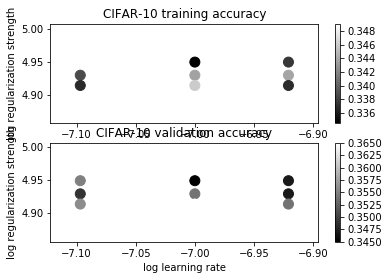

In [65]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [66]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.356000


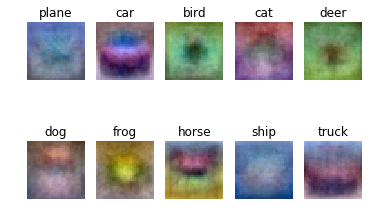

In [67]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** SO t